## PD_MIT-CS1PD dataset

### Ground truth loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nqDataLoader as nq  #data loading library
from sklearn.model_selection import train_test_split
import h5py

### Load all the files

In [2]:
# load ground Ground Truth 
cs1PdFr = pd.read_csv( 'MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv' )
# set Patient ID as index
cs1PdFr = cs1PdFr.set_index('pID')
# load ground Ground Truth 
cs2PdFr = pd.read_csv( 'MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv' )
# set Patient ID as index
cs2PdFr = cs2PdFr.set_index('pID')
# show part of Data Frame
# cs2PdFr.head()

In [3]:
filenames = ['file_1', 'file_2']
patients = pd.DataFrame(columns=['id', 'hold', 'label'])
def load_all(record):
    global filenames, patients
    name = record.name
    
    arr = np.empty(shape=(0, 0))
    arr_press = np.empty(shape=(0, 0))
    arr_release = np.empty(shape=(0, 0))
    keyp = pd.Series()
    for filename in filenames:
        keyPressed, htArr, pressArr, releaseArr = \
                nq.getDataFiltHelper( 'MIT-CS1PD/data_MIT-CS1PD/' + cs1PdFr.loc[name][filename])
        arr = np.append(arr, htArr)
        arr_press = np.append(arr_press, pressArr)
        arr_release = np.append(arr_release, releaseArr)
        keyp = keyp.append(pd.Series(keyPressed))
        
    patients = patients.append({'id': name, 'hold': arr, 'key': keyp, 'label': record['gt'], 'press': arr_press, 
                               'release': arr_release}, ignore_index=True)
    return True

def load_all_d2(record):
    global patients
    filenames = ['file_1']
    name = record.name
    
    arr = np.empty(shape=(0, 0))
    arr_press = np.empty(shape=(0, 0))
    arr_release = np.empty(shape=(0, 0))
    keyp = pd.Series()
    for filename in filenames:
        keyPressed, htArr, pressArr, releaseArr = \
                nq.getDataFiltHelper( 'MIT-CS2PD/data_MIT-CS2PD/' + cs2PdFr.loc[name][filename])
        arr = np.append(arr, htArr)
        arr_press = np.append(arr_press, pressArr)
        arr_release = np.append(arr_release, releaseArr)
        keyp = keyp.append(pd.Series(keyPressed))
        
    patients = patients.append({'id': name, 'hold': arr, 'key': keyp, 'label': record['gt'], 'press': arr_press, 
                               'release': arr_release}, ignore_index=True)
    return True

def remove_quotes(row):    
    return list(row.apply(lambda x: x.replace('"', '')))

    
tmp = cs1PdFr.apply(lambda x: load_all(x), axis=1)
tmp = cs2PdFr.apply(lambda x: load_all_d2(x), axis=1)

patients.set_index('id', inplace=True)

patients['key'] = patients['key'].apply(lambda x: remove_quotes(x))

nqDataLoader.py:87: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(fileIn, dtype=None, delimiter=',', skip_header=0)


### Encoding B

In [4]:
frequency = 100  # Hz

In [5]:
patients.head()

,hold,label,key,press,release
id,,,,,
11,"[0.1713, 0.1432, 0.0655, 0.1188, 0.0737, 0.065...",True,"[a, b, i, a, space, u, n, a, space, v, e, a, s...","[2.4568, 2.7748, 2.9139, 3.0805, 3.1564, 3.435...","[2.6281, 2.918, 2.9794, 3.1992, 3.2301, 3.5004..."
60,"[0.0895, 0.0954, 0.1738, 0.1078, 0.166, 0.1361...",False,"[d, e, l, space, e, n, f, a, d, o, space, l, e...","[2.6084, 2.8721, 3.9054, 5.2092, 5.893, 6.3525...","[2.6979, 2.9675, 4.0792, 5.317, 6.0589, 6.4886..."
67,"[0.1119, 0.1345, 0.3396, 0.1883, 0.1592, 0.134...",True,"[f, u, e, space, r, e, c, o, g, i, d, o, space...","[1.3361, 1.9241, 2.6734, 3.1709, 3.6996, 4.082...","[1.4481, 2.0585, 3.0129, 3.3591, 3.8588, 4.217..."
68,"[0.1194, 0.1337, 0.1847, 0.1499, 0.2137, 0.164...",False,"[n, t, e, r, o, comma, space, q, u, e, space, ...","[1.8314, 2.4218, 2.8949, 3.2413, 3.9616, 6.467...","[1.9508, 2.5555, 3.0796, 3.3912, 4.1754, 6.631..."
70,"[0.1528, 0.208, 0.2084, 0.1539, 0.177, 0.2055,...",True,"[period, l, a, space, p, s, a, d, e, r, a, spa...","[0.6356, 6.0042, 6.4526, 8.0744, 9.0555, 9.484...","[0.7884, 6.2122, 6.661, 8.2283, 9.2325, 9.6897..."


### Encode all patients

In [6]:
'''code here returns
   the length of longest series (in seconds)
'''
# np.array(range(maxlen*freq)) / freq
def find_max(array):
    return array[-1]

max(patients['release'].apply(lambda x: find_max(x)))  # biggest release time value is 1747 seconds

1747.0699

In [7]:
# maxlen = 1750  # this is now standard length for all the files (in seconds)
# timestep = np.arange(start=0, stop=maxlen, step=np.float(1.0/frequency))

def encode(patient, freq=frequency):
    n_decimals = int(np.log10(freq))
    timestep = np.arange(start=0, stop=int(patient['release'][-1]), step=np.float(1.0/frequency))
    sample = np.zeros((timestep.shape[0], 1))
    patient['press'] = np.round_(patient['press'], decimals=n_decimals)
    patient['hold'] = np.round_(patient['hold'], decimals=n_decimals)
    patient['release'] = np.round_(patient['release'], decimals=n_decimals)
    
    for idx in range(patient['hold'].shape[0]):
        start = patient['press'][idx]
        finish = patient['release'][idx]
        
        size_of_insert = int(np.round_((finish - start) * freq, decimals=n_decimals))
        start_id = int(start * (10 ** n_decimals))
        
        try:
            sample[start_id: start_id + size_of_insert] = sample[start_id: start_id + size_of_insert] + np.ones((size_of_insert, 1))  # the change is here
        except:
            sample = np.concatenate((sample, np.zeros((start_id + size_of_insert - sample.shape[0], 1))))
            sample[start_id: start_id + size_of_insert] = sample[start_id: start_id + size_of_insert] + np.ones((size_of_insert, 1))  # end here
    return {'encoded': sample, 'label': patient['label']}

def enc_table(table):
    
    return table.apply(lambda x: encode(x), axis=1)

# patients['encoded'] = patients.apply(lambda x: encode(x), axis=1)
X_train = pd.DataFrame(enc_table(patients))
X_train = X_train[0].apply(pd.Series)
X_train['label'] = X_train['label'].astype(int)

In [8]:
print(X_train.shape)
X_train.head()

(85, 2)


,encoded,label
id,,
11,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1
60,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0
67,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1
68,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0
70,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1


In [9]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

/home/ao2u17/.conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


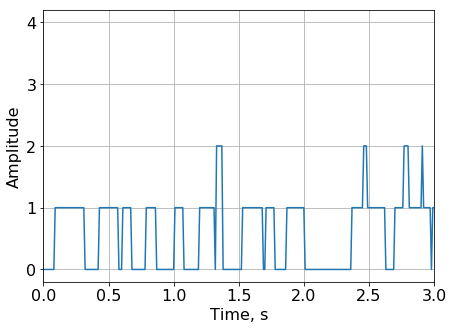

In [10]:
fig1 = plt.figure(figsize=(7, 5))
plt.plot([i/100.0 for i in range(len(X_train['encoded'].iloc[0]))], X_train['encoded'].iloc[0])
plt.xlim((0, 3))

plt.xlabel("Time, s")
plt.ylabel("Amplitude")
# plt.xticks()
# plt.legend(loc='upper right')
# plt.xlim((50, 250))
# plt.ylim((0, 100))
plt.grid()
# plt.savefig('graphs/encb.png')
plt.show()

In [12]:
X_train['encoded'].iloc[0]

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

### Chunk time series

In [13]:
def chunk_one_patient(series, size, overlap):
    arr = np.array(chunk_array(series['encoded'], size, overlap))
    target = np.array([series['label'] for i in range(arr.shape[0])])
    return [arr, target]

def chunk_array(array, size, overlap):
#     print(array.shape)
    gen = gen_split_overlap(array, size, overlap)
    
    result = []
    for arr in gen:
        # if it's the last arr add zeros (if it's 0.7 of size)
        if arr.shape[0] != size:
            if np.float(arr.shape[0]) / np.float(size) >= 0.7:
                arr = np.concatenate((arr, np.zeros((size - arr.shape[0], 1))))
            else:
                continue
        
        result.append(arr)
#         print(arr.shape)
    return result
    

def gen_split_overlap(seq, size, overlap):
    if size < 1 or overlap < 0:
        raise ValueError('size must be >= 1 and overlap >= 0')

    for i in range(0, len(seq) - overlap, size - overlap):            
        yield seq[i: i + size]

In [14]:
chunk_size = 500  # number of data points in one chunk
overlap = 0.0     # overlapping between chunks in percents of chunk_size
overlap = int(overlap*chunk_size)

# one_patient = chunk_one_patient(X_train.iloc[0], chunk_size, overlap)
# one_patient = one_patient.transpose()
# one_patient.rename(columns={0: "data", 1: "part", 2: 'row', 3: 'target'})

res_df = pd.DataFrame()
res_df = X_train.apply(lambda x: chunk_one_patient(x, chunk_size, overlap), axis=1)
res_df = pd.DataFrame(res_df.apply(pd.Series))
res_df = res_df.rename(columns={0: "data", 1: "target"})

In [15]:
# Concatenate rows all together
train_set = np.array((0, 0, 0))
target_set = np.array(0)

def concat_train(row):
    global train_set
    try: 
        train_set.shape[0]
        train_set = np.concatenate([train_set, row])
    except:
        train_set = row

def concat_target(row):
    global target_set
    try: 
        target_set.shape[0]
        target_set = np.concatenate([target_set, row])
    except:
        target_set = row
        
tmp = res_df['data'].apply(lambda x: concat_train(x))
tmp = res_df['target'].apply(lambda x: concat_target(x))


print('X_train shape', train_set.shape)
print('Y_train shape', target_set.shape)

('X_train shape', (14806, 500, 1))
('Y_train shape', (14806,))


### Split training and testing instances

In [16]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=15)

In [17]:
target_set = target_set.astype(int)

### Save data

In [18]:
h5f = h5py.File('encoding_B_freq{freq}_chunks{size}_over{over}.h5'.format(freq=frequency, size=chunk_size, over=overlap), 'w')
h5f.create_dataset('train', data=train_set)
h5f.create_dataset('target', data=target_set)
h5f.close()